In [53]:
import numpy as np
import pandas as pd
import vector
import os

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# mplhep for CMS-style plots
import mplhep as hep

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [54]:
# set up directory to save plots
plot_dir = "../../../plots/MatchingStudy/23Aug15/"
_ = os.system(f"mkdir -p {plot_dir}")

In [18]:
events = pd.read_parquet(
    "../../../0-1.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)

In [19]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "Msd" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [94]:
gen_higgs = make_vector(events, "GenHiggs")
# gen_bs shape: [# events, # Higgs (2), # b's (2)]
gen_bs = make_vector(events, "Genb").reshape(-1, 2, 2)

# sort higgs by pT
pt_argsort = np.argsort(gen_higgs.pt, axis=1)[:, ::-1]
gen_higgs = np.take_along_axis(gen_higgs, pt_argsort, 1)
# need to use np.newaxis to have same # of dimensions as gen_higgs (broadcasting)
gen_bs = np.take_along_axis(gen_bs, pt_argsort[..., np.newaxis], 1)
bh_dR = gen_bs.deltaR(gen_higgs[..., np.newaxis])
bs_dR = gen_bs[:, :, 0].deltaR(gen_bs[:, :, 1])

### Matching

In [104]:
matching_dR = 1
num_gen_bs_close = np.sum(bs_dR < matching_dR, axis=1)

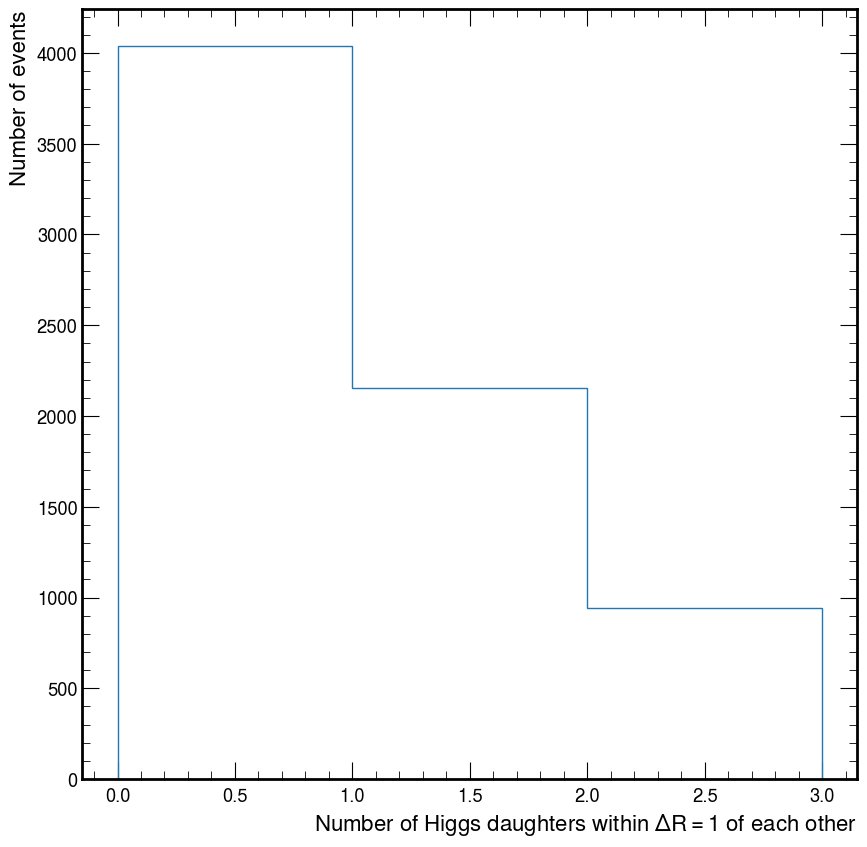

In [110]:
plt.hist(num_gen_bs_close, [0, 1, 2, 3], histtype="step")
plt.ylabel("Number of events")
plt.xlabel(r"Number of Higgs daughters within $\Delta R = 1$ of each other")
plt.savefig(f"{plot_dir}/matching_dr1.pdf")
plt.show()

### Plots

In [95]:
def plot_higgs_hist(vals: np.ndarray, bins: np.ndarray, xlabel: str, filename: str):
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(2):
        ax.hist(vals[:, i].reshape(-1), bins, histtype="step", label=f"Higgs {i + 1}")

    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of Events")
    hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
    plt.savefig(f"{plot_dir}/{filename}.pdf", bbox_inches="tight")
    plt.show()

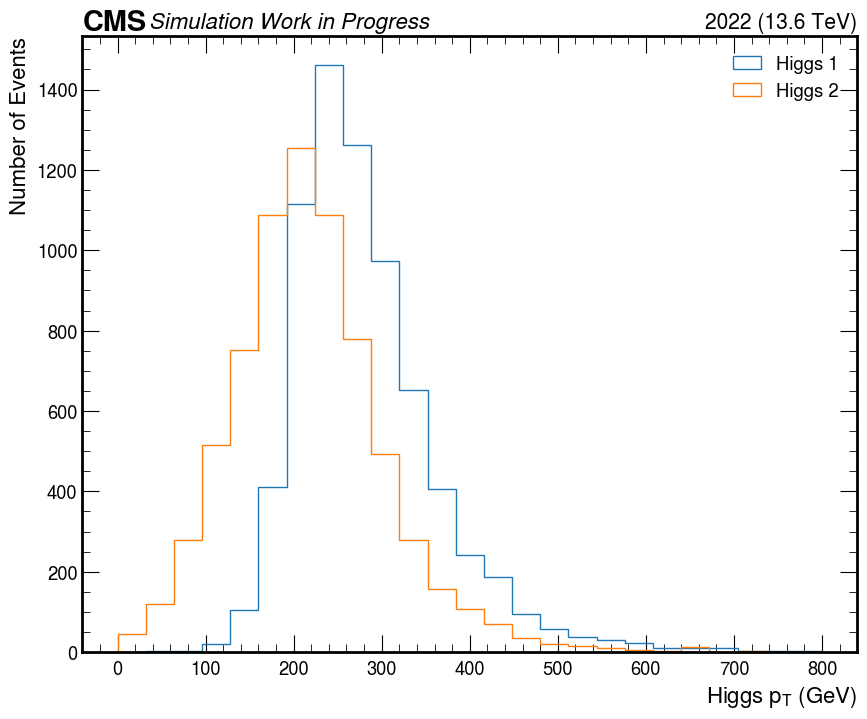

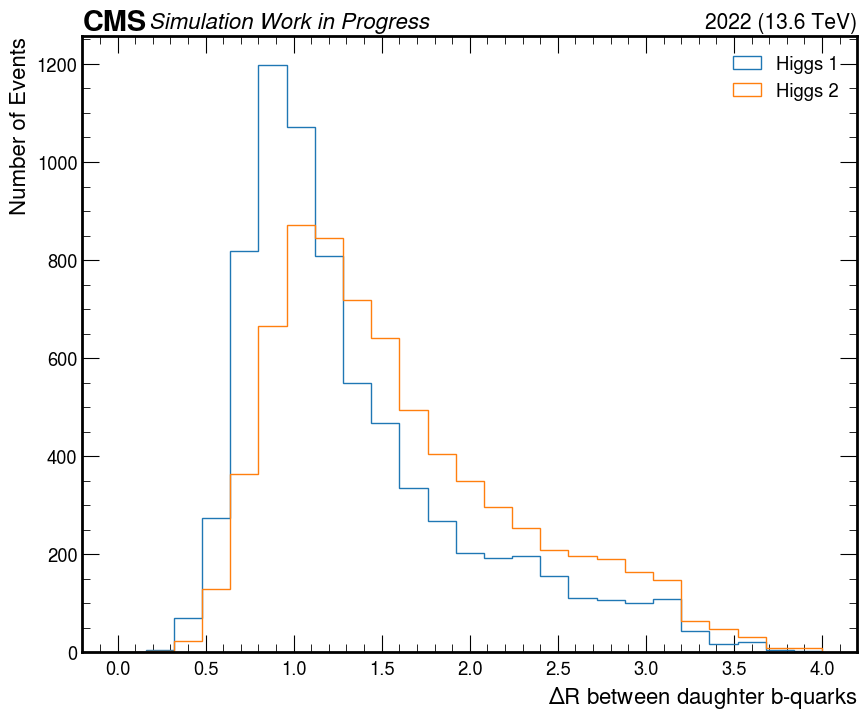

In [108]:
# plot Higgs pT
plot_higgs_hist(gen_higgs.pt, np.linspace(0, 800, 26), rf"Higgs $p_T$ (GeV)", "higgspt")
# plot Higgs-b-quark dR
plot_higgs_hist(bs_dR, np.linspace(0, 4, 26), rf"$\Delta R$ between daughter $b$-quarks", "bs_dR")